# Mounting drive
All the images of the dataset are uploaded in a folder called "DeepLearning" on our google drive. The first task is thus to mount the drive to be able to retrieve our images later.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries

In [ ]:
import os
import json
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import random
import torchvision

# Constants

In [ ]:
CURR_DIR = os.getcwd()
DATA_DIR = os.path.join(CURR_DIR, "drive", "MyDrive", "DeepLearning", "Br35H-Mask-RCNN")
TRAIN_DIR = os.path.join(DATA_DIR, "TRAIN")
VAL_DIR = os.path.join(DATA_DIR, "VAL")
TEST_DIR = os.path.join(DATA_DIR, "TEST")
MASK_DIR = os.path.join(DATA_DIR, "MASK")
MODEL_DIR = os.path.join(DATA_DIR, "MODEL")
PRED_DIR = os.path.join(DATA_DIR, "PREDICTIONS")
SEED = 1

In [ ]:
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

# Masks creation
Initially the dataset contains all the images and their corresponding annotations inside a .json file. For the sake of simplicity we create the mask of each image and save it under a folder in our drive. Later we will be able to access them quite easily. 

In [ ]:
if not os.path.exists(MASK_DIR):
  os.makedirs(MASK_DIR, exist_ok=True)

# All the image directories that need mask creation and their corresponding .json
# file
directories = [TRAIN_DIR, VAL_DIR, TEST_DIR]
files = ["annotations_train.json", "annotations_val.json", "annotations_test.json"]

for i_dir in range(len(directories)):
  dir = directories[i_dir]
  f = files[i_dir]

  file_path = os.path.join(dir, f)

  with open(file_path) as j_file:
    data = json.load(j_file)

  nbr_masks = 0
  poly = 0
  ell = 0

  # Load through the .json file
  for item in data:
    image_file = data[item]["filename"]
    path = os.path.join(dir, image_file)
    im = Image.open(path)
    height, width = im.size

    mask = np.zeros((width, height))
    print("Creating mask for", image_file)

    # An image may contain multiple ROIs
    for i_reg in range(len(data[item]["regions"])):

      if data[item]["regions"][i_reg]["shape_attributes"]["name"] == "polygon":
        # Retrieving important information
        x_points = data[item]["regions"][i_reg]["shape_attributes"]["all_points_x"]
        y_points = data[item]["regions"][i_reg]["shape_attributes"]["all_points_y"]

        # Creating all pairs of end points
        end_points = []
        for i_p, x in enumerate(x_points):
          end_points.append([x, y_points[i_p]])
        end_points = np.array(end_points)

        # Adding polygon on the mask 
        cv2.fillPoly(mask, [end_points], color=(255))

        poly += 1

      elif data[item]["regions"][i_reg]["shape_attributes"]["name"] == "ellipse":
        # Retrieving important information
        cx = data[item]["regions"][i_reg]["shape_attributes"]["cx"]
        cy = data[item]["regions"][i_reg]["shape_attributes"]["cy"]
        rx = data[item]["regions"][i_reg]["shape_attributes"]["rx"]
        ry = data[item]["regions"][i_reg]["shape_attributes"]["ry"]
        theta = data[item]["regions"][i_reg]["shape_attributes"]["theta"]

        # Adding ellipse on the mask
        mask = cv2.ellipse(mask, (cx, cy), 
                           (int(round(rx)), int(round(ry))), 
                           theta*360, 0, 360, color=(255), thickness=-1)
        ell += 1
      elif data[item]["regions"][i_reg]["shape_attributes"]["name"] == "circle":
        # Retrieving important information
        cx = data[item]["regions"][i_reg]["shape_attributes"]["cx"]
        cy = data[item]["regions"][i_reg]["shape_attributes"]["cy"]
        r = data[item]["regions"][i_reg]["shape_attributes"]["r"]

        # Adding circle on the mask
        mask = cv2.circle(mask, (cx, cy), int(round(r)), color=(255), thickness=-1)
        
      else:
        print("Unrecognised shape:", data[item]["regions"][i_reg]["shape_attributes"]["name"])
        print(data[item]["regions"][i_reg]["shape_attributes"])
    
    nbr_masks += 1
    cv2.imwrite(os.path.join(MASK_DIR, image_file), mask)

  print("Mask:", nbr_masks)
  print("Polygons:", poly)
  print("Ellipses:", ell)

# Dataset

In [ ]:
class Br35H_Dataset(torch.utils.data.Dataset):
  def __init__(self, img_dir, mask_dir, im_tr, mask_tr):
    super().__init__()
    self.imgs = img_dir
    self.masks = mask_dir
    self.transform_image = im_tr
    self.transform_mask = mask_tr
    self.dataset = [item for item in os.listdir(self.imgs) if ".jpg" in item]

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, index):
    name = self.dataset[index]
    img = Image.open(os.path.join(self.imgs, name)).convert('L')
    mask = Image.open(os.path.join(self.masks, name))
    im_size = img.size
    return self.transform_image(img), self.transform_mask(mask), name, [im_size[0], im_size[1]]

## Dataset pad and resize

In [ ]:
class Br35H_Dataset_PadNResize(torch.utils.data.Dataset):
  def __init__(self, img_dir, mask_dir, im_tr, mask_tr):
    super().__init__()
    self.imgs = img_dir
    self.masks = mask_dir
    self.transform_image = im_tr
    self.transform_mask = mask_tr
    self.dataset = [item for item in os.listdir(self.imgs) if ".jpg" in item]

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, index):
    name = self.dataset[index]
    img = Image.open(os.path.join(self.imgs, name)).convert('L')
    mask = Image.open(os.path.join(self.masks, name))
    im_size = img.size
    length = im_size[0]
    height = im_size[1]
    
    tr = transforms.Compose([transforms.ToTensor(),
                             transforms.Resize((512, 512))])
    
    if length > height:
      delta = length - height
      if delta % 2 == 0:
        pads = [0,delta//2,0,delta//2]
      else:
        pads = [0,(delta//2)+1,0,delta//2]
          
      tr = transforms.Compose([transforms.ToTensor(),
                                transforms.Pad(padding = pads),
                                transforms.Resize((512, 512))])
        
    if height > length:
      delta = height - length
      if delta % 2 == 0:
        pads = [delta//2,0,delta//2,0]
      else:
        pads = [(delta//2)+1,0,delta//2,0]
          
      tr = transforms.Compose([transforms.ToTensor(),
                                transforms.Pad(padding = pads),
                                transforms.Resize((512, 512))])

    return tr(img), tr(mask), name, [im_size[0], im_size[1]]

# UNet

In [ ]:
class DoubleConv(nn.Module):
  def __init__(self, in_ch, out_ch):
    super(DoubleConv, self).__init__()
    self.network = nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
        nn.ReLU()
    )

  def forward(self, x):
    return self.network(x)


class UNET(nn.Module):
  def __init__(self, in_ch, n_classes):
    super(UNET, self).__init__()

    self.DConv_1 = DoubleConv(in_ch, 64)
    self.BN1 = nn.BatchNorm2d(64)
    self.pool = nn.MaxPool2d(2)
    self.DConv_2 = DoubleConv(64, 128)
    self.BN2 = nn.BatchNorm2d(128)
    self.DConv_3 = DoubleConv(128, 256)
    self.BN3 = nn.BatchNorm2d(256)
    self.DConv_4 = DoubleConv(256, 512)
    self.BN4 = nn.BatchNorm2d(512)
    self.DConv_5 = DoubleConv(512, 1024)

    self.upConv_1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
    self.DConv_6 = DoubleConv(1024, 512)

    self.upConv_2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
    self.DConv_7 = DoubleConv(512, 256)

    self.upConv_3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
    self.DConv_8 = DoubleConv(256, 128)

    self.upConv_4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
    self.DConv_9 = DoubleConv(128, 64)

    self.conv = nn.Conv2d(64, n_classes, kernel_size=1)


  def forward(self, x):
      #
      x1 = self.DConv_1(x)
      x1 = self.BN1(x1)
      x_1 = self.pool(x1)

      #
      x2 = self.DConv_2(x_1)
      x2 = self.BN2(x2)
      x_2 = self.pool(x2)
      
      #
      x3 = self.DConv_3(x_2)
      x3 = self.BN3(x3)
      x_3 = self.pool(x3)

      #
      x4 = self.DConv_4(x_3)
      x4 = self.BN4(x4)
      x_4 = self.pool(x4)

      #
      x5 = self.DConv_5(x_4)

      # Up
      x6 = self.upConv_1(x5)
      x6 = torch.cat((x4, x6), dim=1)
      x7 = self.DConv_6(x6)

      #
      x8 = self.upConv_2(x7)
      x8 = torch.cat((x3, x8), dim= 1)
      x9 = self.DConv_7(x8)

      #
      x10 = self.upConv_3(x9)
      x10 = torch.cat((x2, x10), dim=1)
      x11 = self.DConv_8(x10)

      #
      x12 = self.upConv_4(x11)
      x12 = torch.cat((x1, x12), dim=1)
      x13 = self.DConv_9(x12)

      #
      x14 = self.conv(x13)

      return x14

# Train

Variables

In [ ]:
BATCH_SIZE = 4
WORKERS = 0 
DEVICE_NAME = "cpu"
if torch.cuda.is_available():
    DEVICE_NAME = 'cuda:0'
DEVICE = torch.device(DEVICE_NAME)

LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0

OPTIMIZER = "ADAM"
LOSS = "CE"

EPOCHS = 30

In [ ]:
im_transform = transforms.Compose([transforms.ToTensor(), 
                                   transforms.Resize((512,512))])

mask_transform = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Resize((512,512))])

training_set = Br35H_Dataset(TRAIN_DIR, MASK_DIR, im_transform, mask_transform)
validation_set = Br35H_Dataset(VAL_DIR, MASK_DIR, im_transform, mask_transform)

training_loader = torch.utils.data.DataLoader(training_set, BATCH_SIZE, shuffle = True, num_workers=WORKERS)
validation_loader = torch.utils.data.DataLoader(validation_set, BATCH_SIZE, shuffle = True, num_workers=WORKERS)

In [ ]:
# Unet 3 IF RGB, 1 if gray
model = UNET(1, 2)
best_model = UNET(1, 2)
best_model = model
model.to(DEVICE)

# Loss function
criterion = nn.CrossEntropyLoss()
criterion_string = "CE"

# Optimiser
optimiser = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
optimiser_string = "Adam" + "_" + "LR" + str(LEARNING_RATE) + "_" + "WD" + str(WEIGHT_DECAY)

# Params
params_string = "Params" + "_" + "Epochs" + str(EPOCHS) + "_" + "BS" + str(BATCH_SIZE) + "_" + "W" + str(WORKERS)

# Model name
model_name = criterion_string + optimiser_string + params_string

file_name = model_name + ".txt"
f = open(os.path.join(DATA_DIR, file_name), "a")
f.write("Name: " + model_name + "_" + DEVICE_NAME + "\n\n")
f.close()

In [ ]:
if not os.path.exists(MODEL_DIR):
  os.makedirs(MODEL_DIR, exist_ok=True)

Actual training

In [ ]:
best_valid_loss = float('inf')
train_loss_tot = []
valid_loss_tot = []

for epoch in range(EPOCHS):
    print("Epoch:", epoch)
    
    "Trianing the model"
    model.train()
    epoch_loss = 0
    #print("Training:")
    for image, mask, _, _ in training_loader:
        predictions = model(image.to(DEVICE))
        mask = mask.type(torch.LongTensor)
        mask = torch.squeeze(mask, 1)

        loss = criterion(predictions, mask.to(DEVICE))
        curr_loss = loss.detach().item()
        epoch_loss += curr_loss
        #print("Batch loss:", curr_loss)
      
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    train_loss = epoch_loss / len(training_loader)
    #print("Training loss:", str(train_loss))

    
    "Validating the model"
    model.eval()
    epoch_loss = 0
    #print("Validating:")
    with torch.no_grad():
        for image, mask, _, _ in validation_loader:
            predictions= model(image.to(DEVICE))
            mask = mask.type(torch.LongTensor)
            mask = torch.squeeze(mask, 1)
            
            loss = criterion(predictions, mask.to(DEVICE))
            curr_loss = loss.detach().item()
            epoch_loss += curr_loss
            #print("Batch loss:", curr_loss)

    valid_loss = epoch_loss / len(validation_loader)
    
    print("Training loss:", str(train_loss))
    print("Validation loss:", valid_loss)
    print("-------------")

    train_loss_tot.append(train_loss)
    valid_loss_tot.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_string = model_name + "_Best" + str(epoch) + "_Val" + str(best_valid_loss)
        torch.save(model.state_dict(), os.path.join(MODEL_DIR, best_string + "_" + DEVICE_NAME + ".pth"))

    f = open(os.path.join(DATA_DIR, file_name), "a")
    f.write("Epoch: " + str(epoch) + "\n")
    f.write("Train: " + str(train_loss) + "\n")
    f.write("Validate: " + str(valid_loss) + "\n")
    f.write("All train: " + str(train_loss_tot) + "\n")
    f.write("All validate: " + str(valid_loss_tot) + "\n")
    f.write("Current best model: " + best_string + "_" + DEVICE_NAME + ".pth" + "\n\n")
    f.close()

    torch.save(model.state_dict(), os.path.join(MODEL_DIR, model_name + "_" + DEVICE_NAME + ".pth"))

f = open(os.path.join(DATA_DIR, file_name), "a")
f.write("------------------------------------------------------------------------------------------------------------------------\n\n")
f.close()

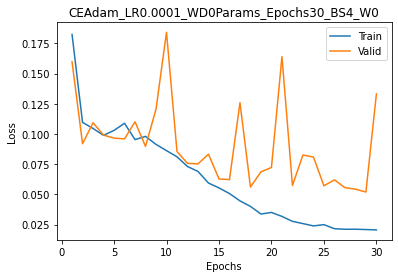

In [ ]:
#Print loss
epochs = [i+1 for i in range(EPOCHS)]
plt.plot(epochs, train_loss_tot, label='Train')
plt.plot(epochs, valid_loss_tot, label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(model_name)
plt.legend()
plt.show() 

# Evaluate

Metrics and functions

In [ ]:
# Code for the confusion matrix:
# https://gist.github.com/the-bass/cae9f3976866776dea17a5049013258d
def confusion_matrix(prediction, truth):
    """ Returns the confusion matrix for the values in the `prediction` and `truth`
    tensors, i.e. the amount of positions where the values of `prediction`
    and `truth` are
    - 1 and 1 (True Positive)
    - 1 and 0 (False Positive)
    - 0 and 0 (True Negative)
    - 0 and 1 (False Negative)
    """
    prediction = prediction.reshape(-1)
    truth = truth.reshape(-1)

    confusion_vector = prediction/truth

    # Element-wise division of the 2 tensors returns a new tensor which holds a
    # unique value for each case:
    #   1     where prediction and truth are 1 (True Positive)
    #   inf   where prediction is 1 and truth is 0 (False Positive)
    #   nan   where prediction and truth are 0 (True Negative)
    #   0     where prediction is 0 and truth is 1 (False Negative)

    true_positives = torch.sum(confusion_vector == 1).item()
    false_positives = torch.sum(confusion_vector == float('inf')).item()
    true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
    false_negatives = torch.sum(confusion_vector == 0).item()

    return true_positives, false_positives, true_negatives, false_negatives

def precision(prediction, truth):
    tp, fp, tn, fn = confusion_matrix(prediction, truth)
    if tp == 0:
        return 0
    return tp / (tp + fp)

def recall(prediction, truth):
    tp, fp, tn, fn = confusion_matrix(prediction, truth)
    if tp == 0:
        return 0
    return tp / (tp + fn)

def F1Score(prediction, truth):
    tp, fp, tn, fn = confusion_matrix(prediction, truth)
    return (2 * tp) / (2 * tp + fp + fn)

def IOUScore(prediction, truth):
    tp, fp, tn, fn = confusion_matrix(prediction, truth)
    return tp / (tp + fp + fn)

In [ ]:
# https://github.com/Cytomine-ULiege/S_Segment-ML-UNet-Binary-Pred
# Slightly modified by us
def predict_img(model, image, device, transform, out_threshold=0.5):
    with torch.no_grad():
        x = image
        logits = model(x.to(device))
        logits = transform(logits)
        y_pred = nn.Softmax(dim=1)(logits)
        proba = y_pred.detach().cpu().squeeze(0).numpy()[1, :, :]
        return proba > out_threshold

Variables

In [ ]:
im_transform = transforms.Compose([transforms.ToTensor(), 
                                   transforms.Resize((512,512))])

mask_transform = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Resize((512,512))])

testing_set = Br35H_Dataset(TEST_DIR, MASK_DIR, im_transform, mask_transform)
testing_loader = torch.utils.data.DataLoader(testing_set, batch_size=1, shuffle = False, num_workers=WORKERS)

Actual evaluation

In [ ]:
# Name of the model to load, replace with another name if needed
name = best_string + "_" + DEVICE_NAME
name += ".pth"

run_name = name

model_path = os.path.join(MODEL_DIR, name)

# Unet 3 IF RGB, 1 if gray
model = UNET(1, 2)
model.load_state_dict(torch.load(model_path))
model.to(DEVICE)

tps = 0
precisions = []
recalls = []
F1s = []
IOUs = []

model.eval()
for image, mask, name, size in testing_loader:
    image_name = name[0]
    untr = transforms.Compose([transforms.Resize((size[1].item(),size[0].item()))])
    prediction = predict_img(model, image, DEVICE, untr)
    pred = torch.from_numpy(prediction)
    
    precisions.append(precision(pred, untr(mask)))
    recalls.append(recall(pred, untr(mask)))
    F1s.append(F1Score(pred, untr(mask)))
    IOUs.append(IOUScore(pred, untr(mask)))
    
confidence = 0.9
print("Name of the run: {}".format(run_name))
print("Precision: {}".format(np.mean(precisions)))
print("90% CI: {}".format(np.percentile(precisions, [100*(1-confidence)/2,100*(1-(1-confidence)/2)])))
print("Min, max:", np.min(precisions), np.max(precisions))
print()

print("Recall: {}".format(np.mean(recalls)))
print("90% CI: {}".format(np.percentile(recalls, [100*(1-confidence)/2,100*(1-(1-confidence)/2)])))
print("Min, max:", np.min(recalls), np.max(recalls))
print()
      
print("F1/Dice score: {}".format(np.mean(F1s)))
print("90% CI: {}".format(np.percentile(F1s, [100*(1-confidence)/2,100*(1-(1-confidence)/2)])))
print("Min, max:", np.min(F1s), np.max(F1s))
print()

print("IoU: {}".format(np.mean(IOUs)))
print("90% CI: {}".format(np.percentile(IOUs, [100*(1-confidence)/2,100*(1-(1-confidence)/2)])))
print("Min, max:", np.min(IOUs), np.max(IOUs))


# Mask creation and Manipulation

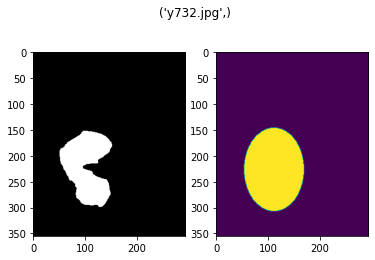

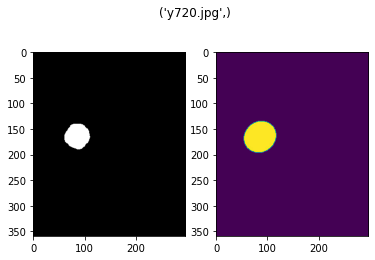

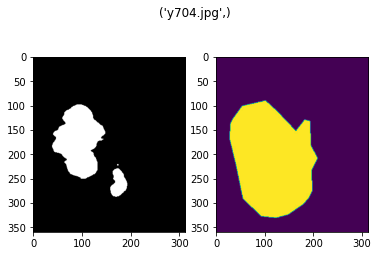

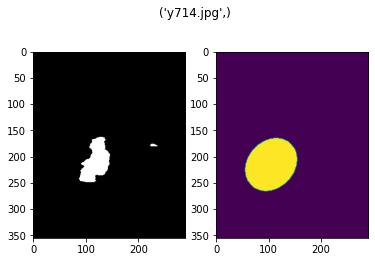

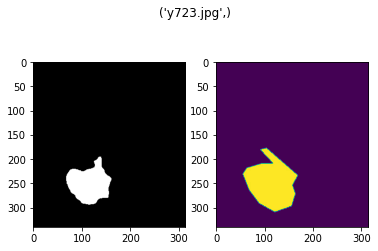

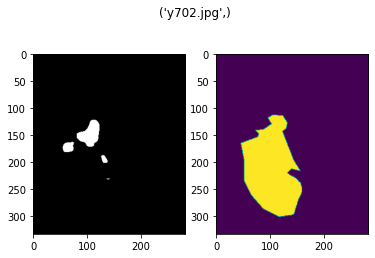

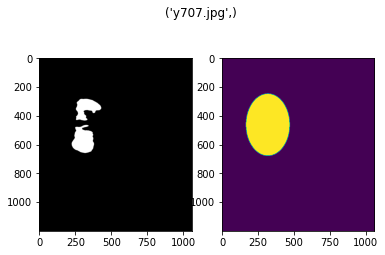

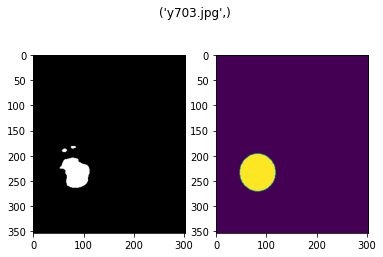

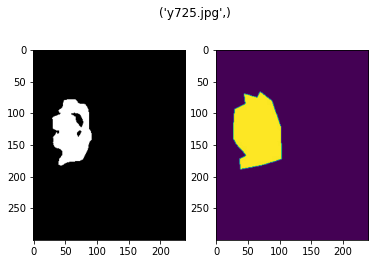

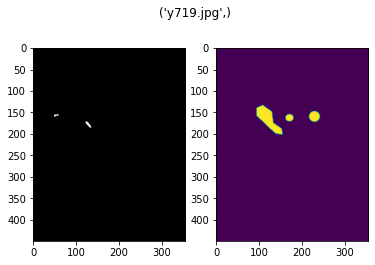

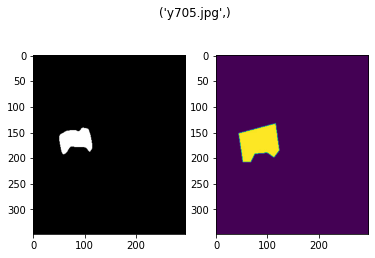

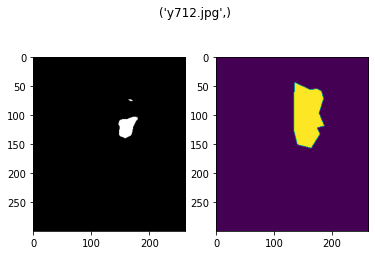

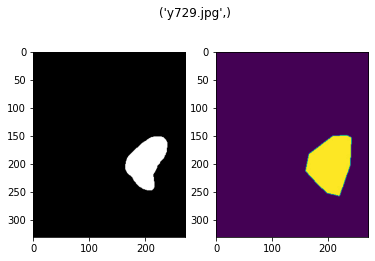

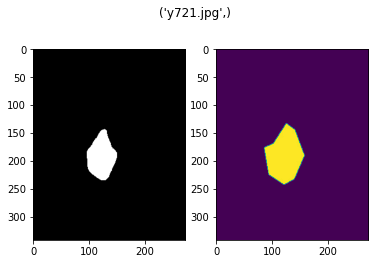

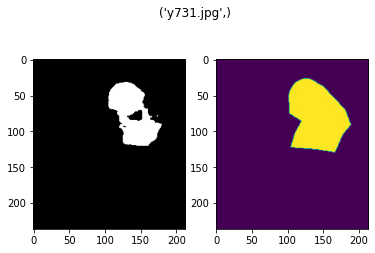

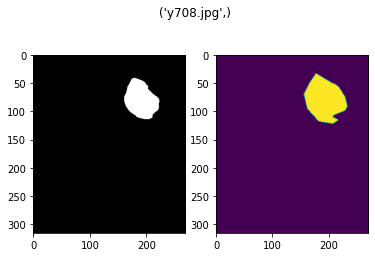

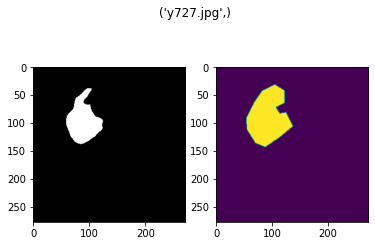

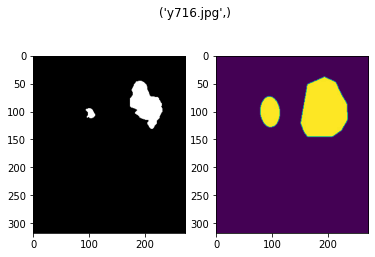

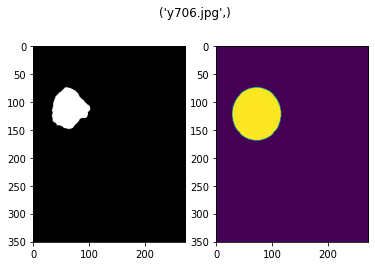

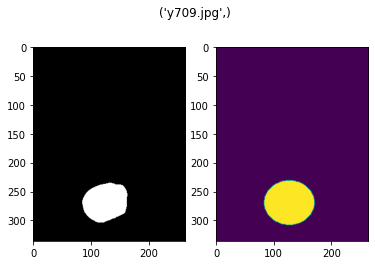

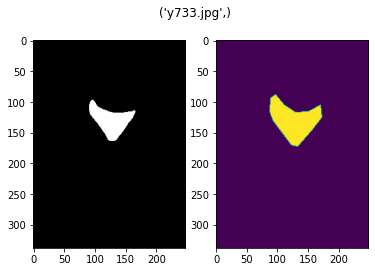

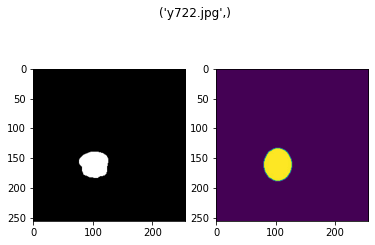

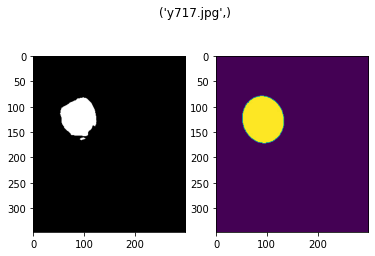

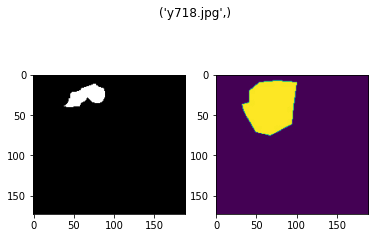

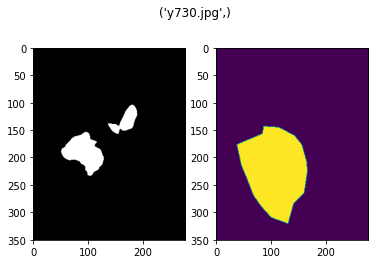

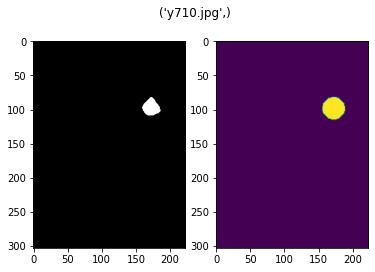

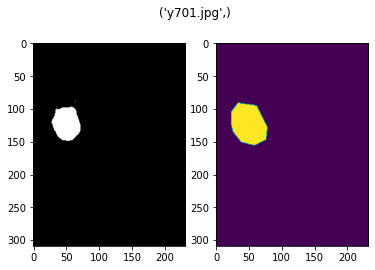

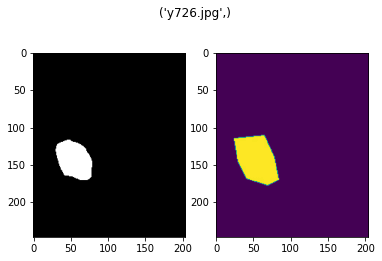

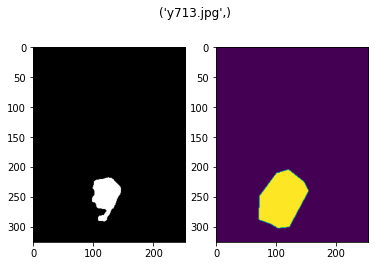

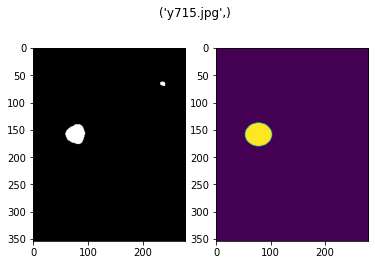

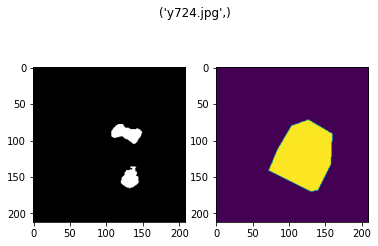

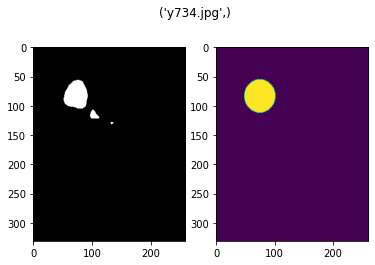

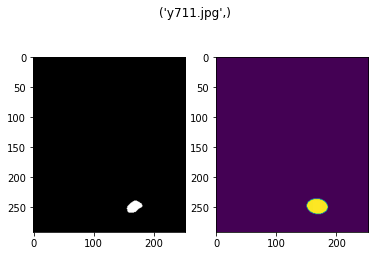

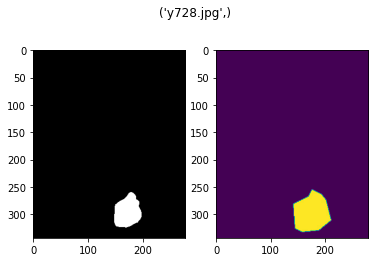

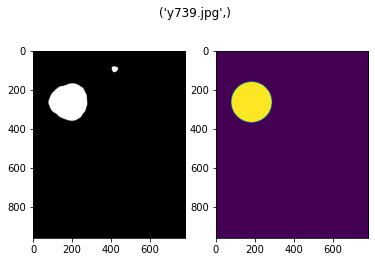

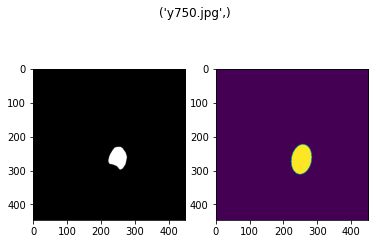

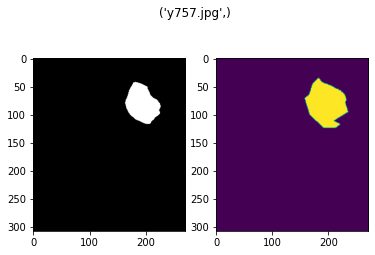

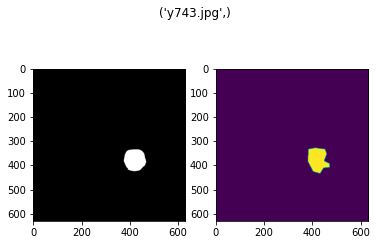

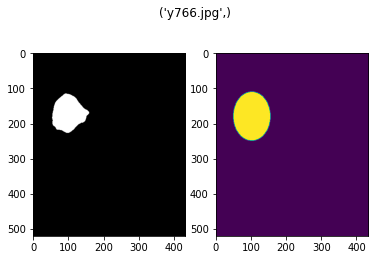

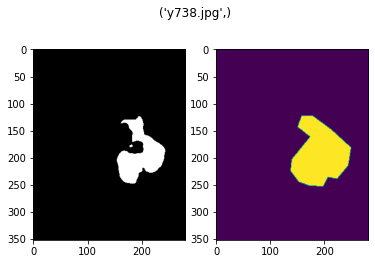

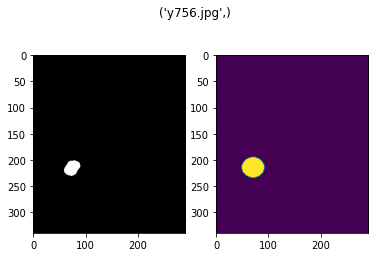

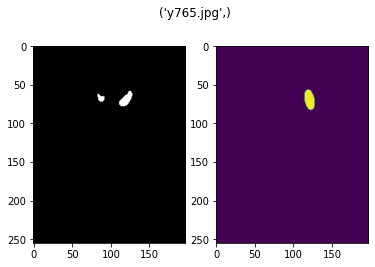

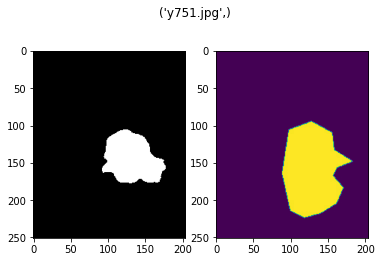

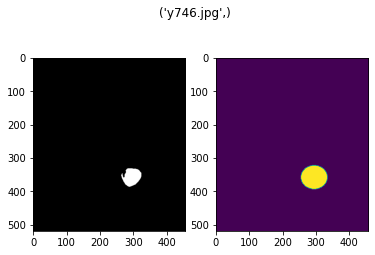

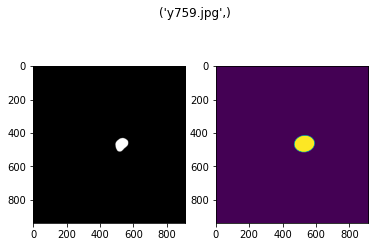

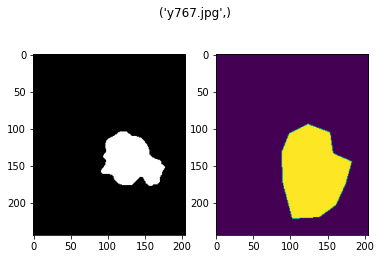

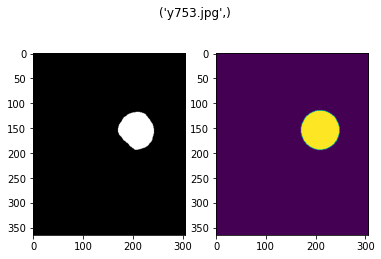

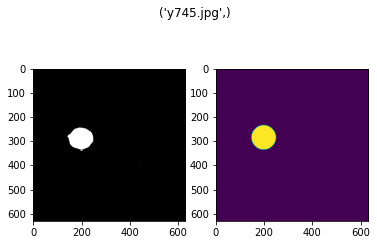

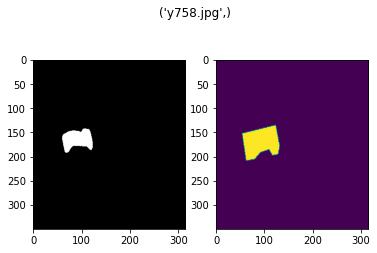

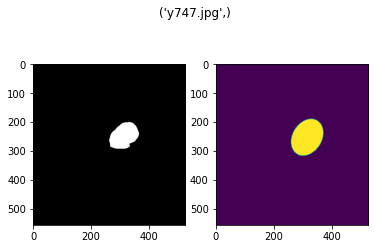

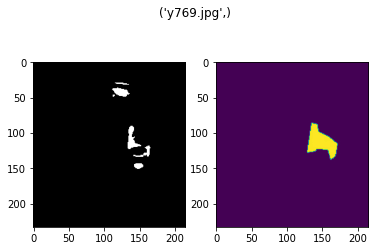

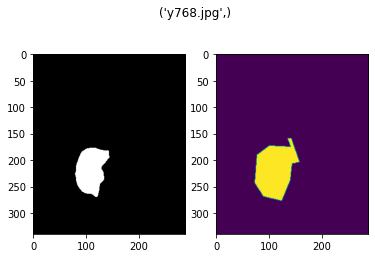

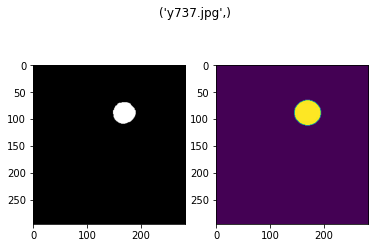

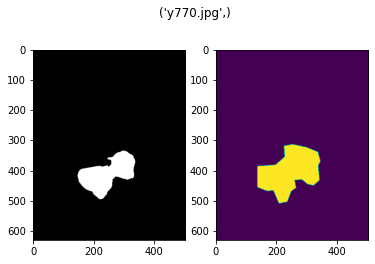

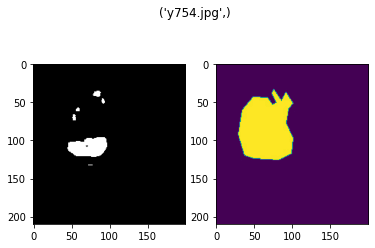

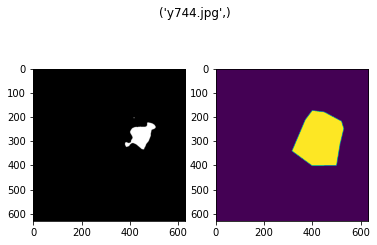

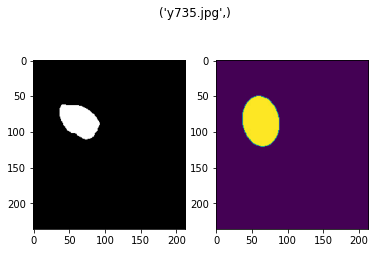

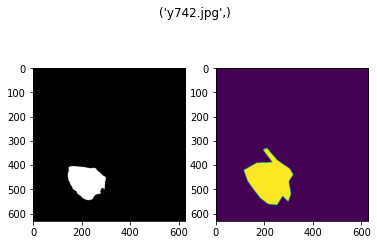

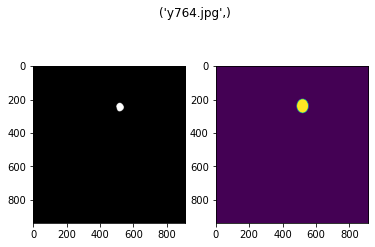

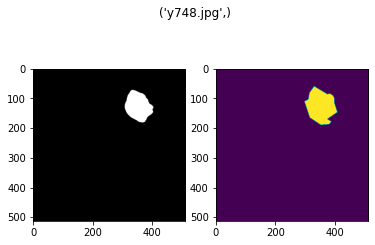

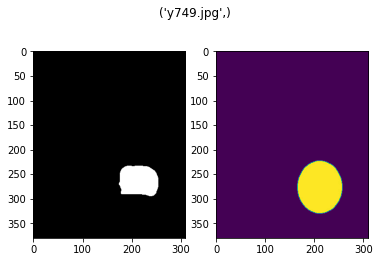

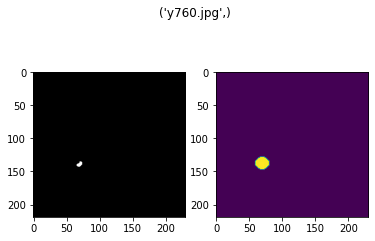

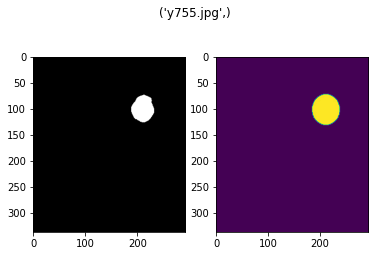

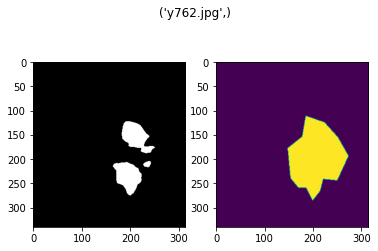

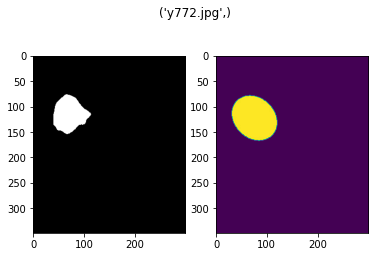

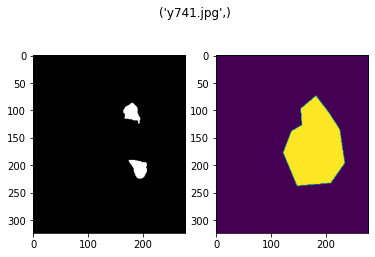

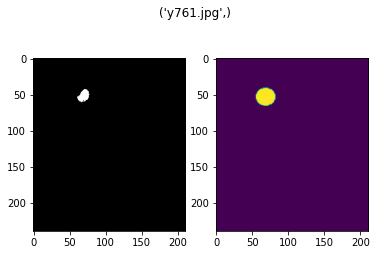

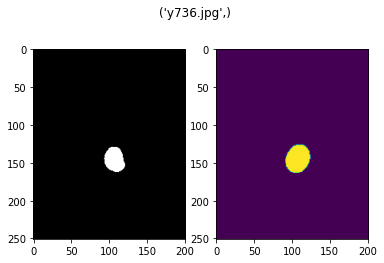

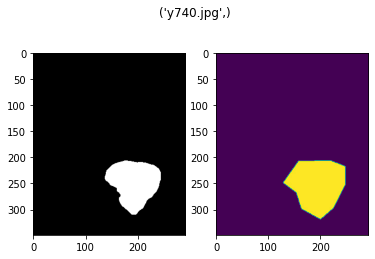

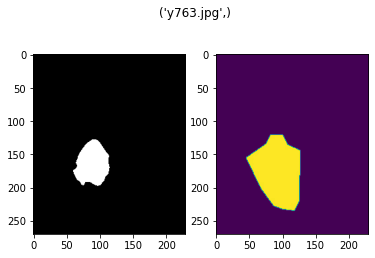

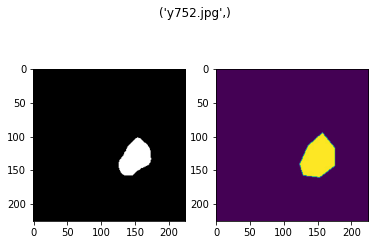

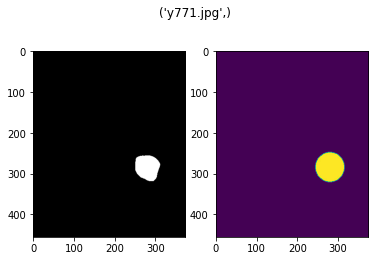

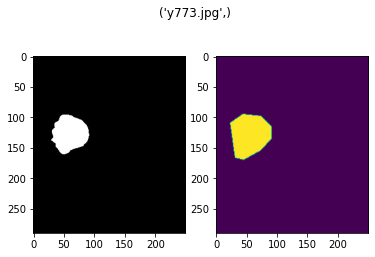

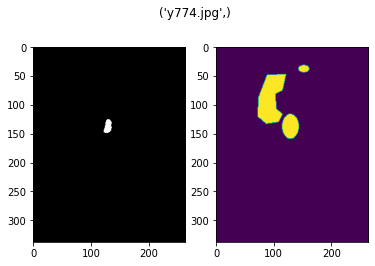

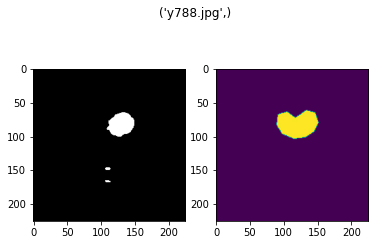

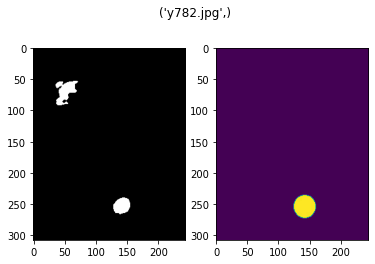

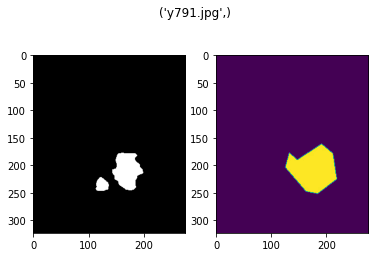

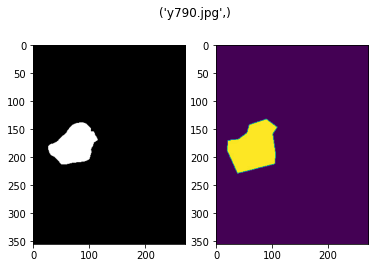

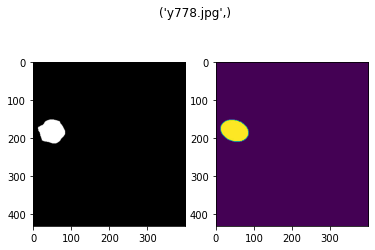

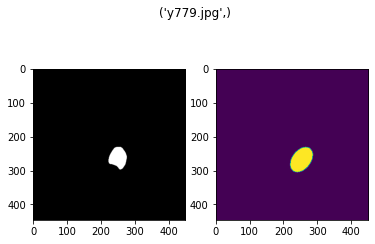

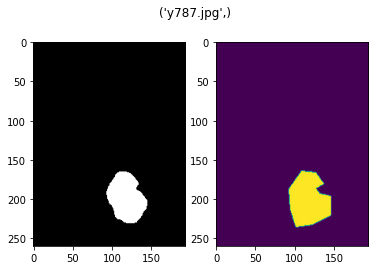

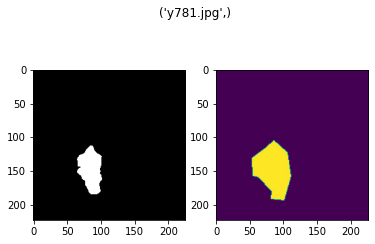

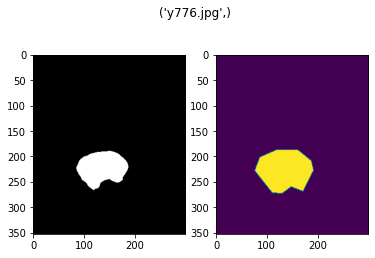

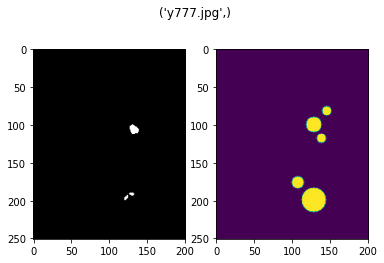

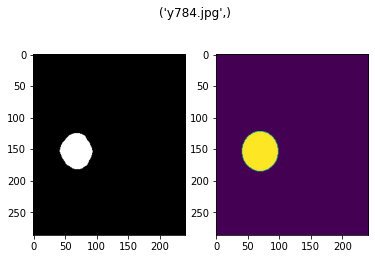

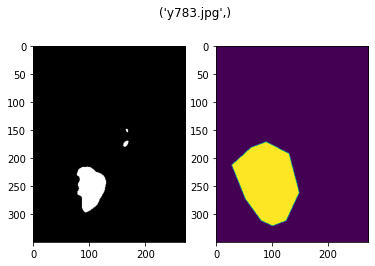

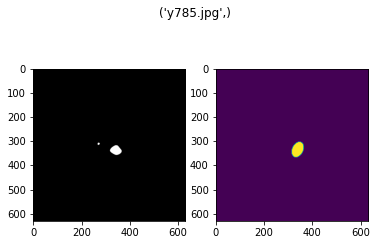

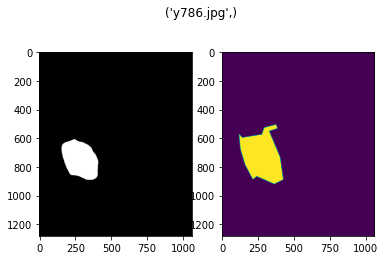

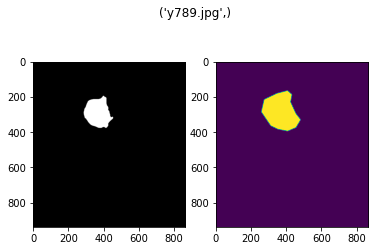

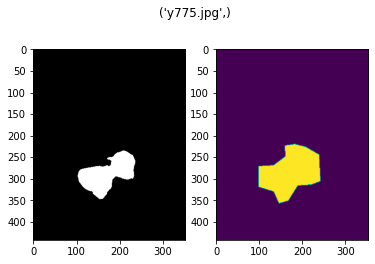

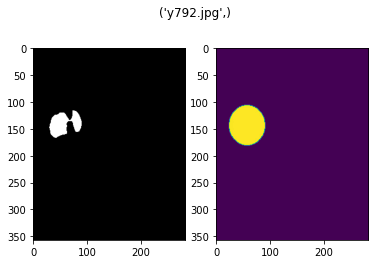

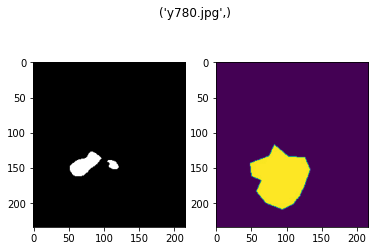

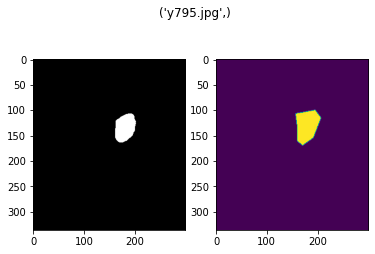

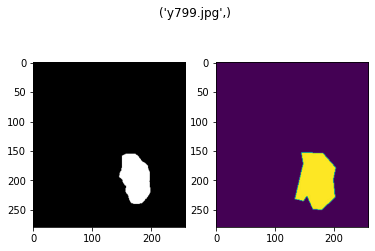

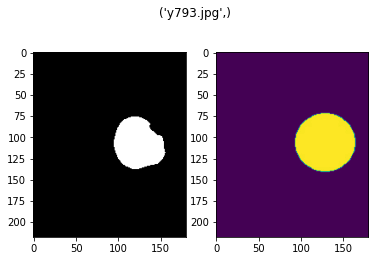

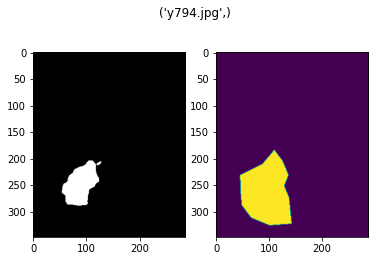

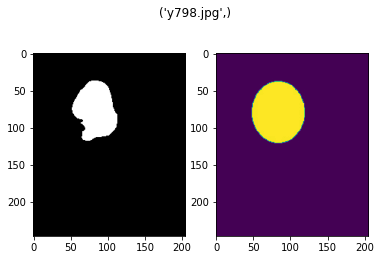

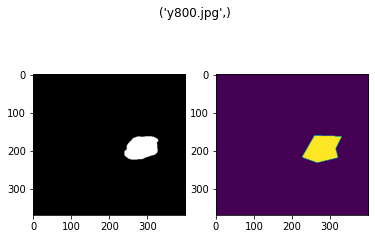

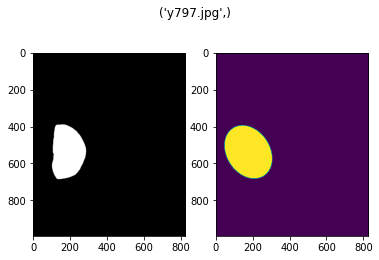

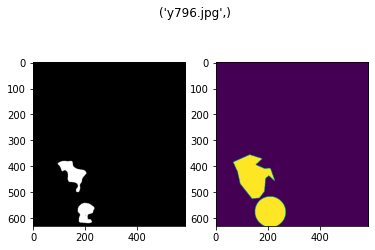

In [ ]:
# Name of the model to load, replace with another name if needed
name = best_string + "_" + DEVICE_NAME
name += ".pth"

if not os.path.exists(PRED_DIR):
    os.makedirs(PRED_DIR, exist_ok=True)
    
save_path = os.path.join(PRED_DIR, best_string + "_" + DEVICE_NAME)
os.makedirs(save_path, exist_ok=True)

model_path = os.path.join(MODEL_DIR, name)

# Unet 3 IF RGB, 1 if gray
model = UNET(1, 2)
model.load_state_dict(torch.load(model_path))
model.to(DEVICE)

tps = 0
precisions = []
recalls = []
F1s = []
IOUs = []

for image, mask, name, size in testing_loader:
    image_name = name[0]
    untr = transforms.Compose([transforms.Resize((size[1].item(),size[0].item()))])
    prediction = predict_img(model, image, DEVICE, untr)
    drawn = Image.fromarray(prediction)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(name)
    ax1.imshow(drawn)
    ax2.imshow(transforms.functional.to_pil_image(untr(mask[0])))

    plt.show()
    drawn.save(os.path.join(save_path, image_name))
    

In [ ]:
# Create comparison of the two masks
im_transform = transforms.Compose([transforms.ToTensor()])

mask_transform = transforms.Compose([transforms.ToTensor()])

run_name = best_string + "_" + DEVICE_NAME

directory = os.path.join(PRED_DIR, run_name)

dataset = Br35H_Dataset(directory, MASK_DIR, im_transform, mask_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle = False, num_workers=0)

for prediction, groundtruth, name, size in dataloader:
  prediction = torch.squeeze(prediction)
  groundtruth = torch.squeeze(groundtruth)
  division = prediction / groundtruth
  name = name[0]

  comparison = torch.zeros(size=(3,size[1].item(), size[0].item()))
  # True positives
  comparison[0, division == 1] = 255/255
  comparison[1, division == 1] = 255/255
  comparison[2, division == 1] = 255/255

  # False positive
  comparison[0, division == float('inf')] = 255/255
  comparison[1, division == float('inf')] = 128/255
  comparison[2, division == float('inf')] = 0/255

  # False negatives
  comparison[0, division == 0] = 0/255
  comparison[1, division == 0] = 204/255
  comparison[2, division == 0] = 204/255

  save_name = "ZComparison_" + name
  
  torchvision.utils.save_image(comparison, fp=os.path.join(directory,save_name))
  